In [1]:
# reading ERA5 vertical profile data, running through a year,
#  and outputting a mean grid for each of 3 longitude 'slices' of 45deg width
# 10/1/18 fixed bug in calculation of daytime-only zonal means
# updated 11/1 to remove 'interpolated' values below surface, using sfc pressure
from netCDF4 import Dataset
import glob

In [2]:
ecdir = '/home/dudavid/Dendrite/Dendrite/UserAreas/Dave/EC/'
yr = '15' # year 20x
#dn = 'night' # day/night flag, new 2/1/18
slices = ['0E_12-15Z','90W_18-21Z','105E_3-6Z']
#de = 6 # time delta, in hours, around midday/midnight. i.e. 6 means 6-18/18-6, 3 = 9-15/21-3
#ctr= 12 # local solar time to center on i.e. noon=12, 1:30pm=13.5
ts = 3 # time step in hrs of data (cant be changed--downloaded this way)
mons = sorted(glob.glob(ecdir+'vert'+yr+'*/')) # the vertical profile data are kept in separate folders
print(len(mons))
#ordr = [11,0,1,2,3,4,5,6,7,8,9,10]
#mons = [mons[i] for i in ordr]
#print(mons) # run in order DJF/MMA/JJA/SON/
#hrs = str(ctr)+'_'+str(ctr-de)+'to'+str(ctr+de) #'0to24'

nz = 23 # common p levels from ERA5/MERRA and subset from DARDAR
#plvs = [1013,1000,975,950,925,900,875,850,825,800,775,750,700,650,600,550,\
plvs = [1000,975,950,925,900,875,850,825,800,775,750,700,650,600,550,\
        500,450,400,350,300,250,200,150,100]#[::-1]
plvs = [l*100.0 for l in plvs] # into Pa
pavg = [(plvs[i+1]+plvs[i])*.5 for i in range(len(plvs)-1) ]
print(pavg)
dp = [plvs[i]-plvs[i+1] for i in range(nz)]#[::-1] # hPa to Pa, reversed to match EC order below
#print(dp) # flipped from relative to plvs
ecsubs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,24,25]
#EC HAS: 1000,  975,  950,  925,  900,  875,  850,  825,  800,  775,  750,
#        700,  650,  600,  550,  500,  450,  400,  350,  300,  250,  225,
#        200,  175,  150,  100] # for reference, reverse order
zees = [111,323,540,762,988,1220,1457,1700,1949,2204,2466,3012,3590,4206,4864,\
        5573,6343,7184,8116,9162,10361,11782,13606,16000]
# altitude values back-calculated using same int'l standard atmosphere (isa.py) at above p levels
dz = [zees[i+1]-zees[i] for i in range(len(zees)-1)]
print('dz',dz)
print(len(plvs),len(zees),nz,len(ecsubs))

12
[98750.0, 96250.0, 93750.0, 91250.0, 88750.0, 86250.0, 83750.0, 81250.0, 78750.0, 76250.0, 72500.0, 67500.0, 62500.0, 57500.0, 52500.0, 47500.0, 42500.0, 37500.0, 32500.0, 27500.0, 22500.0, 17500.0, 12500.0]
dz [212, 217, 222, 226, 232, 237, 243, 249, 255, 262, 546, 578, 616, 658, 709, 770, 841, 932, 1046, 1199, 1421, 1824, 2394]
24 24 23 24


In [3]:
gsize = 2.5 # in degrees, normal grid (downloaded this way. if wanting to change output grid, do elsewhere)
# downloaded at much coarser grid for comparison to DARDAR
latmax= 90  # NS latitude limits of grid (downloaded this way)
nx, ny = int(360.0/gsize), int(2.0*latmax/gsize)+1 
nx = 19 # overriden because only taking 3hr slice of longitudes, 45/360
nnx = 3 # just means of slices?
# EC has points AT lat/lon intersections, so EC data actually -180 to 179.5, -90 to 90
mean_grid_iwc = np.zeros([nz, ny, nnx])
mean_grid_swc = np.zeros([nz, ny, nnx])
#zonal_mean_iwp = np.zeros(ny)
#zonal_mean_swp = np.zeros(ny)
count = 0 # initialize
ndays = 0
#iwpall = []

In [10]:
avg_iw, avg_sw = np.zeros([nz,ny,nnx]), np.zeros([nz,ny,nnx])
for m in mons:#[0:2]:
    mo = m[len(m)-3:len(m)-1]
    #print(mo)
    #if mo == '12' or mo == '03' or mo == '06' or mo == '09': #reset for each new season
    #    mean_grid_iwps = np.zeros([ny, nx])
    #    mean_grid_swps = np.zeros([ny, nx])
    #    counts = 0 # initialize
    #    ndayss = 0
    #    if mo=='12': seas = 'DJF'
    #    if mo=='03': seas = 'MAM'
    #    if mo=='06': seas = 'JJA'
    #    if mo=='09': seas = 'SON'
        
    nd = int(len(sorted(os.listdir(m)))/3) # all daily files in the month:
    print(nd)
    print('starting mon: ',m)
    for d in range(nd):#[0:1]:
        da = str(d+1).rjust(2,'0')
        for fi in range(3):
            file = 'era5.pl.90NS.'+da+'.'+mo+'.20'+yr+'.2.5deg.'+slices[fi]+'.nc'
            f = Dataset(m+file,'r')
            pfile = 'era5.sp.90NS.'+da+'.'+mo+'.20'+yr+'.2.5deg.'+slices[fi]+'.nc'
            pf = Dataset(ecdir+'vert_sp'+yr+mo+'/'+pfile,'r')
            sp = np.mean(pf['sp'][:],axis=0)[:,:] # mean of time dim, now [ny,nx]
            iwc, swc = np.array(f['ciwc']), np.array(f['cswc'])  #"specific ice/snow water content" in kg/kg
            iwc[iwc < 1e-12] = 0.0 # remove infinitesimal values
            swc[swc < 1e-12] = 0.0
            # arrays are [2,26,73,19]. first average first (time) dimension:
            #iwc, swc = np.mean(iwc,axis=0)[ecsubs,:,:], np.mean(swc,axis=0)[ecsubs,:,:]
            iwc, swc = np.mean(iwc,axis=0)[:,:,:], np.mean(swc,axis=0)[:,:,:]
            
            # convert from specific wc to mixing ratio and into g/m^3
            # -----such a miniscule difference it's hardly worth the computation!! --------
            iwc_mr, swc_mr = iwc, swc #np.zeros([nz,ny,nx]), np.zeros([nz,ny,nx])
            #iwc_mr, swc_mr = np.zeros([nz,ny,nx]), np.zeros([nz,ny,nx])
            #iwc_mr[iwc > 0] = iwc[iwc>0]/(1-iwc[iwc > 0]*1000) *1000.0 # convert to mixing ratio
            #swc_mr[swc > 0] = swc[swc>0]/(1-swc[swc > 0]*1000) *1000.0 #  [from kg/kg to g/kg]
            #iwc_mr,swc_mr = iwc*1000.0,swc*1000.0
            iw, sw = np.zeros([nz,ny]), np.zeros([nz,ny])
            for z in range(nz): 
                tempiw = (iwc_mr[z+1,:,:]+iwc_mr[z,:,:])*.5 * dp[z] / (9.81 * dz[z])
                tempsw = (swc_mr[z+1,:,:]+swc_mr[z,:,:])*.5 * dp[z] / (9.81 * dz[z])
                #wc = q*p/(g*dz) 
                tempiw[sp < plvs[z]] = np.nan ##set to nan, don't include in lat mean 
                tempsw[sp < plvs[z]] = np.nan ##set to nan, don't include in lat mean 
                iw[z,:] = np.nanmean(tempiw, axis=1)
                sw[z,:] = np.nanmean(tempsw, axis=1)
                # UNITS: kg/m^3 = (kg/kg)(kg/ms^2)(s^2/mm) [P in Pa]
                # lastly, set to NAN any lat band means that use sub-sfc p levels:
                
            avg_iw[:,:,fi] += iw[:,:]
            avg_sw[:,:,fi] += sw[:,:]
        ndays += 1 # count days processed
            
for sl in range(3):
    mean_grid_iwc[:,:,sl] = 1e6*avg_iw[:,:,sl]/float(ndays) #convert to mg/m^3
    mean_grid_swc[:,:,sl] = 1e6*avg_sw[:,:,sl]/float(ndays) #convert to mg/m^3
mean_grid_iwc[mean_grid_iwc < 0] = 0.0
mean_grid_swc[mean_grid_swc < 0] = 0.0
#zonal_mean_iwp /= float(count)
#zonal_mean_swp /= float(count)

31
starting mon:  /home/dudavid/Dendrite/Dendrite/UserAreas/Dave/EC/vert1501/


/home/dudavid/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice
/home/dudavid/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice


KeyboardInterrupt: 

[0.0, 8.6855914680171544, 1.7522456362238159, 1.898553493226]
[0.0, 43.154662773520251, 3.7851265165378507, 5.0790537177131609]


/home/dudavid/src/pyco/dmap.py:137: RuntimeWarning: invalid value encountered in less_equal
  mask = grid <= lowval
/home/dudavid/src/pyco/dmap.py:139: RuntimeWarning: invalid value encountered in greater_equal
  maskh = grid >= hival
/home/dudavid/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


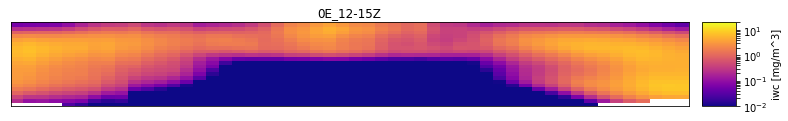

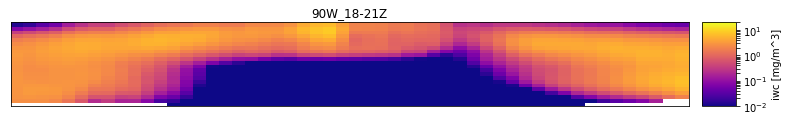

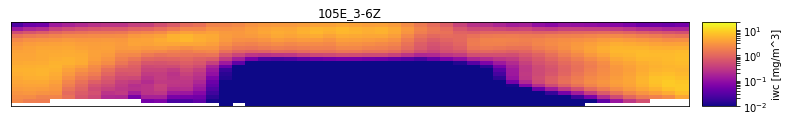

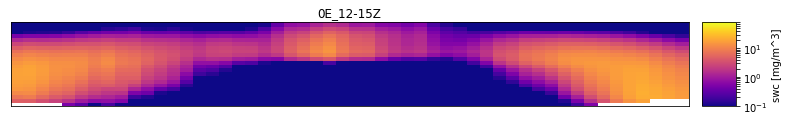

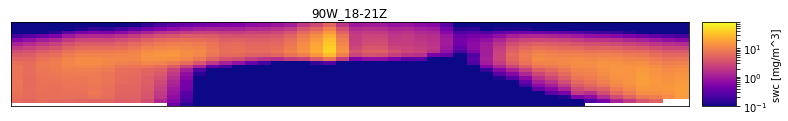

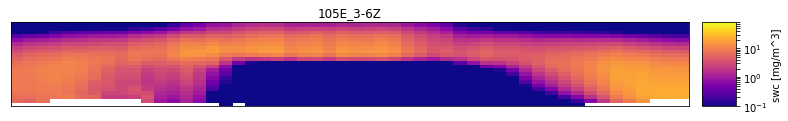

In [8]:
print(info(mean_grid_iwc))
print(info(mean_grid_swc))
#print(mean_grid_iwc[:,ny-24,1])
#print(mean_grid_iwc[1,:,1])
#mean_grid_iwc[mean_grid_iwc != mean_grid_iwc] = 0.0
#mean_grid_swc[mean_grid_swc != mean_grid_swc] = 0.0 #remove nans for plotting?
ml1,ml2=-65,65 #90,90
z1,z2 = 0,16
s1,s2 = 10,ny-10 #0,ny
vi1,vi2,va1,va2 = .01,.1,20,80
f11 = plt.figure(figsize=[13,5])
grdplt((mean_grid_iwc[:,s1:s2,0]),ml1,ml2,z1,z2,vi1,va1,1,0,0,slices[0],'iwc [mg/m^3]')
f21 = plt.figure(figsize=[13,5])
grdplt((mean_grid_iwc[:,s1:s2,1]),ml1,ml2,z1,z2,vi1,va1,1,0,0,slices[1],'iwc [mg/m^3]')
f31 = plt.figure(figsize=[13,5])
grdplt((mean_grid_iwc[:,s1:s2,2]),ml1,ml2,z1,z2,vi1,va1,1,0,0,slices[2],'iwc [mg/m^3]')
f12 = plt.figure(figsize=[13,5])
grdplt((mean_grid_swc[:,s1:s2,0]),ml1,ml2,z1,z2,vi2,va2,1,0,0,slices[0],'swc [mg/m^3]')
f22 = plt.figure(figsize=[13,5])
grdplt((mean_grid_swc[:,s1:s2,1]),ml1,ml2,z1,z2,vi2,va2,1,0,0,slices[1],'swc [mg/m^3]')
f32 = plt.figure(figsize=[13,5])
grdplt((mean_grid_swc[:,s1:s2,2]),ml1,ml2,z1,z2,vi2,va2,1,0,0,slices[2],'swc [mg/m^3]')


In [9]:
nds = str(ndays)
# dataset name, res (x,y), time res of input, output arrays (grids, zonals), version?, # days
#print('hrs: ',hrs)
#if dn == 'night': hrs = '18to6'
#if dn == 'day': hrs = '6to18'
fin = 'grids/era5.vert.3.'+str(ny)+'y.13.5LST.iwp.swp.v2.'+yr+'.'+nds # for now v2 is not changing qi to mr_i
np.save(fin+'.grid',mean_grid_iwc)
#np.save(fin+'.zonal',zonal_mean_iwp)
np.save(fin+'.sgrid',mean_grid_swc)
#np.save(fin+'.szonal',zonal_mean_swp)